- 목표 : 영화 수익을 예측해보자!<br>
<br>
- train : 3000 movies (target : revenue)
- test :  4398 movies

In [399]:
# 그래프에 한글 적용하는 코드
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 그래프에 마이너스 표기하는 코드
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime

In [361]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submit = pd.read_csv('data/sample_submission.csv')

# 1.EDA

### 결측치 확인

In [5]:
print(train.shape)
train.isnull().sum()

(3000, 23)


id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [6]:
print(test.shape)
test.isnull().sum()

(4398, 22)


id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

### revenue
- right skewed

In [413]:
train['revenue_log'] = np.log1p(train['revenue'])

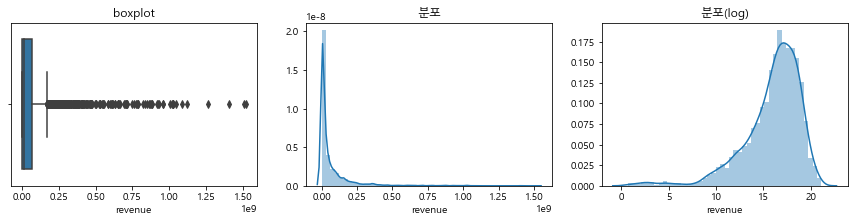

In [405]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3))
sns.boxplot(x = 'revenue', data=train, ax=axes[0])
sns.distplot(train['revenue'], ax=axes[1])
sns.distplot(train['revenue_log'], ax=axes[2])
axes[0].set_title('boxplot')
axes[1].set_title('분포')
axes[2].set_title('분포(log)')
plt.show()

### budget
- right skewed
- 0~12 -> 아닌 경우도 있고 맞는 경우도 있음...outler 처리 필요...😢
- 3억 8천 달러(최대값)가 제작비로 가능한가 -> 캐리비안의 해적:낮선조류로 맞았음...<br>
-> 제작비가 많은 경우는 문제 되지 않으나 적은 경우가 문제....

In [414]:
train['budget_log'] = np.log1p(train['budget'])
test['budget_log'] = np.log1p(test['budget'])

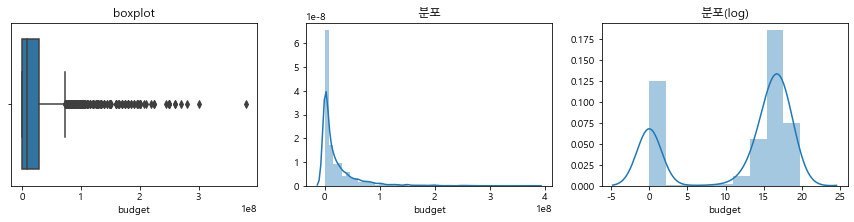

In [406]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3))
sns.boxplot(x = 'budget', data=train, ax=axes[0])
sns.distplot(train['budget'], ax=axes[1])
sns.distplot(train['budget_log'], ax=axes[2])
axes[0].set_title('boxplot')
axes[1].set_title('분포')
axes[2].set_title('분포(log)')
plt.show()

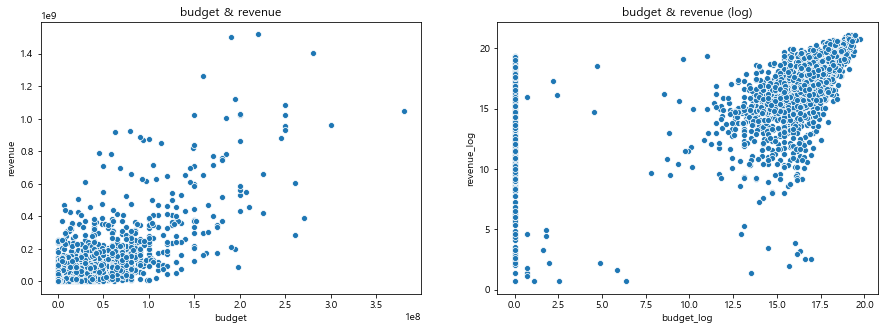

In [418]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot('budget', 'revenue', data=train, ax=axes[0])
sns.scatterplot('budget_log', 'revenue_log', data=train, ax=axes[1])
axes[0].set_title('budget & revenue')
axes[1].set_title('budget & revenue (log)')
plt.show()

### popularity
- right skewed
- outlier는 없는 것 같음....(TMDB 평가 기준 : https://developers.themoviedb.org/3/getting-started/popularity)

In [421]:
train['popularity_log'] = np.log1p(train['popularity'])
test['popularity_log'] = np.log1p(test['popularity'])

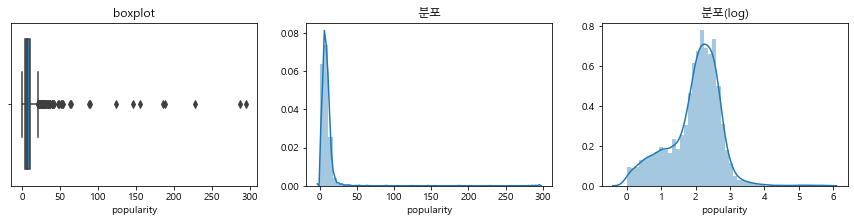

In [422]:
fig, axes = plt.subplots(ncols=3, figsize=(15,3))
sns.boxplot(x = 'popularity', data=train, ax=axes[0])
sns.distplot(train['popularity'], ax=axes[1])
sns.distplot(train['popularity']log, ax=axes[2])
axes[0].set_title('boxplot')
axes[1].set_title('분포')
axes[2].set_title('분포(log)')
plt.show()

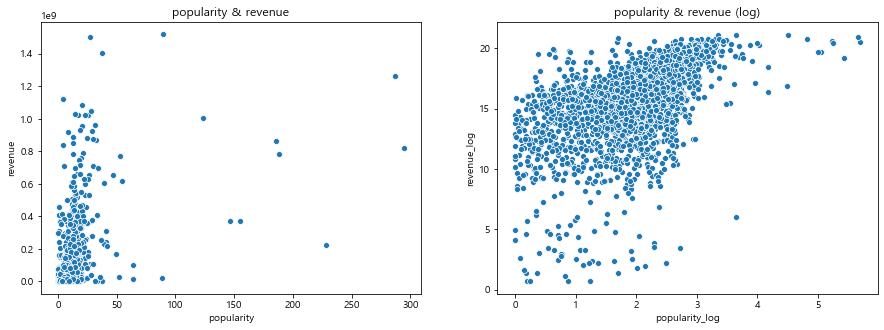

In [423]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot('popularity', 'revenue', data=train, ax=axes[0])
sns.scatterplot('popularity_log', 'revenue_log', data=train, ax=axes[1])
axes[0].set_title('popularity & revenue')
axes[1].set_title('popularity & revenue (log)')
plt.show()

### runtime
- 0은 missing value인 듯...

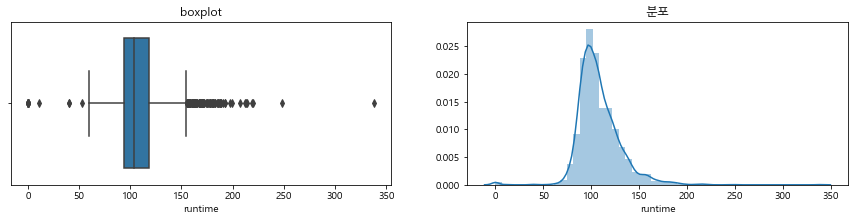

In [424]:
fig, axes = plt.subplots(ncols=2, figsize=(15,3))
sns.boxplot(x = 'runtime', data=train, ax=axes[0])
sns.distplot(train[train['runtime'].notnull()]['runtime'], ax=axes[1])
axes[0].set_title('boxplot')
axes[1].set_title('분포')
plt.show()

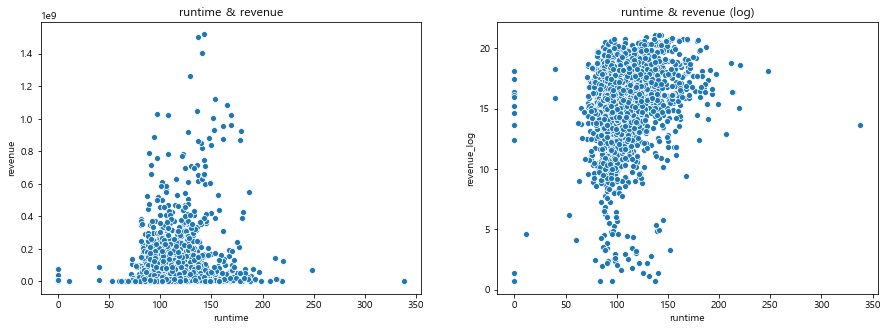

In [425]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot('runtime', 'revenue', data=train, ax=axes[0])
sns.scatterplot('runtime', 'revenue_log', data=train, ax=axes[1])
axes[0].set_title('runtime & revenue')
axes[1].set_title('runtime & revenue (log)')
plt.show()

In [249]:
train[train['runtime']==0][['title','release_date']]

,title,release_date
390,The Worst Christmas of My Life,12/22/12
591,А поутру они проснулись,12/4/03
924,¿Quién mató a Bambi?,11/15/13
977,La peggior settimana della mia vita,10/27/11
1255,"Cry, Onion!",8/25/75
1541,All at Once,6/5/14
1874,Missing,1/1/07
2150,Mechenosets,10/12/06
2498,Hooked on the Game 2. The Next Level,4/15/10
2645,My Old Classmate,4/25/14


### homepage
- 빈도는 소니, 디즈니가 압도적으로 많았음
- 수익률은 디즈니, mgm, 소니 순이었음

In [362]:
# 도메인만 남기기
train['homepage'] = train['homepage'].str.split('/').str[2].str.replace('www.','').str.replace('.com','')
test['homepage'] = test['homepage'].str.split('/').str[2].str.replace('www.','').str.replace('.com','')

In [363]:
# 소니, 디즈니 각각 합치기
""" 소니, 디즈니 
    sonypictures & sonyclassics -> sony
    disney.go & movies.disney -> disney
"""
mapping = {
    'sonypictures': 'sony',
    'sonyclassics': 'sony',
    'disney.go': 'disney',
    'movies.disney': 'disney'
}
domain_train = train['homepage'].map(mapping)
domain_test = test['homepage'].map(mapping)
train['homepage'] = np.where(domain_train.isnull(), train['homepage'], domain_train)
test['homepage'] = np.where(domain_test.isnull(), test['homepage'], domain_test)

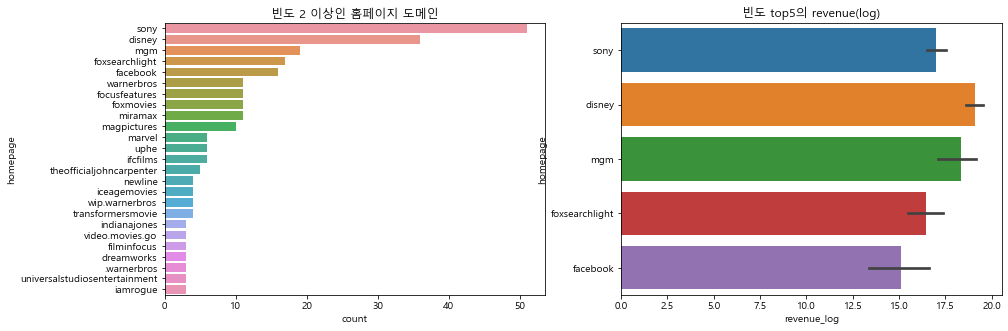

In [453]:
hp_fq = train['homepage'].value_counts()[train['homepage'].value_counts()>2]
temp = train[train['homepage'].isin(hp_fq.index)]
top5 = list(hp_fq[:5].index)
temp2 = train[train['homepage'].isin(top5)]

fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.countplot(y='homepage', data=temp, order=hp_fq.index, ax=axes[0])
sns.barplot( x='revenue_log', y='homepage', data=temp2, order=top5, ax=axes[1])
axes[0].set_title('빈도 2 이상인 홈페이지 도메인')
axes[1].set_title('빈도 top5의 revenue(log)')
plt.show()

### original_language
- 거의 대부분이 영어

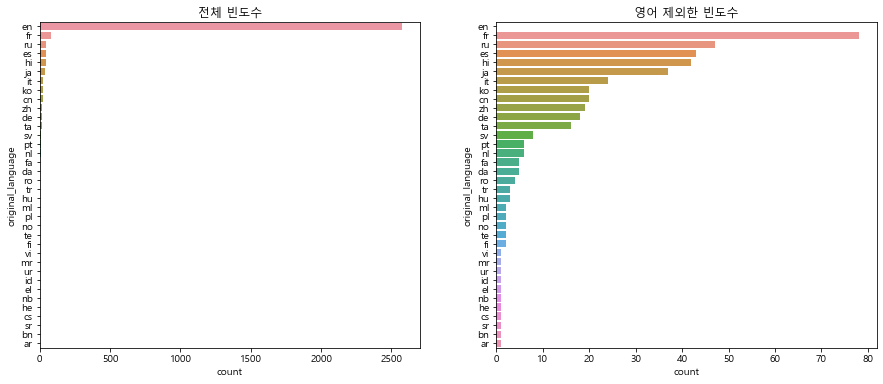

In [129]:
order = train['original_language'].value_counts().index

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,6))
sns.countplot(y = 'original_language', data=train, order=order, ax=axes[0])
sns.countplot(y = 'original_language', data=train[train['original_language']!='en'], order=order, ax=axes[1])
axes[0].set_title('전체 빈도수')
axes[1].set_title('영어 제외한 빈도수')
plt.show()

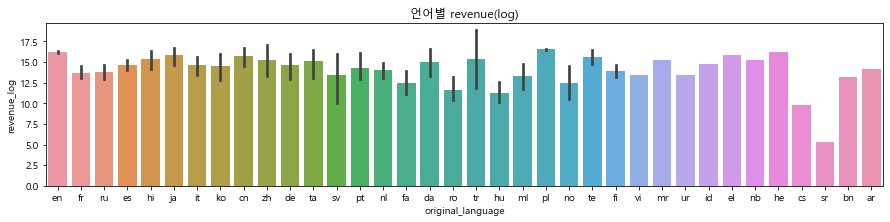

In [465]:
fig, axes = plt.subplots(ncols=1, figsize=(15,3))
sns.barplot(x='original_language', y='revenue_log', data=train, order=order)
axes.set_title('언어별 revenue(log)')
plt.show()

### original_title, title
- 너무나 당연한 결과지만, original_title과 title이 다른 경우 original_language는 위쪽 오른쪽 그래프와 유사해 보임
- title이 동일한 영화 31편 있음

In [292]:
train[train['original_title']!=train['title']]['original_language'].value_counts()

fr    52
ru    44
ja    34
en    34
es    26
cn    20
zh    19
ko    19
it    17
hi    14
de    13
ta     9
sv     7
fa     5
nl     5
da     4
pt     4
ro     3
hu     3
ml     2
no     2
el     1
nb     1
ar     1
vi     1
fi     1
sr     1
te     1
cs     1
ur     1
he     1
bn     1
mr     1
tr     1
pl     1
id     1
Name: original_language, dtype: int64

In [299]:
dup_index = train['title'].value_counts()[train['title'].value_counts()>1].index
train[train['title'].isin(dup_index)]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_year
24,25,NaN,0,"[{'id': 27, 'name': 'Horror'}, {'id': 35, 'nam...",blacksheep-themovie,tt0779982,en,Black Sheep,A genetic engineering experiment gone horribly...,7.434577,...,87.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,There are over 40 million sheep in New Zealand...,Black Sheep,"[{'id': 2658, 'name': 'new zealand'}, {'id': 3...","[{'cast_id': 9, 'character': 'Henry Oldfield',...","[{'credit_id': '52fe43a0c3a36847f8063031', 'de...",4947717,2006
60,61,"[{'id': 645, 'name': 'James Bond Collection', ...",150000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",mgm,tt0381061,en,Casino Royale,"Le Chiffre, a banker to the world's terrorists...",23.065078,...,144.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Everyone has a past. Every legend has a beginn...,Casino Royale,"[{'id': 131, 'name': 'italy'}, {'id': 383, 'na...","[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '53ac1fd7c3a3684bc8001908', 'de...",599045960,2006
122,123,NaN,1500000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0100053,en,Loose Cannons,"Mac, the two fisted savy cop finds that he's b...",1.961208,...,94.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Loose Cannons,"[{'id': 720, 'name': 'helicopter'}, {'id': 155...","[{'cast_id': 2, 'character': 'MacArthur Stern'...","[{'credit_id': '52fe449cc3a368484e02cabf', 'de...",5585154,1990
127,128,NaN,10000000,"[{'id': 27, 'name': 'Horror'}, {'id': 18, 'nam...",NaN,tt0219699,en,The Gift,When a local woman disappears and the police c...,7.886926,...,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The only witness to the crime was not even there.,The Gift,"[{'id': 663, 'name': 'fortune teller'}, {'id':...","[{'cast_id': 1, 'character': 'Annie Wilson', '...","[{'credit_id': '52fe432fc3a36847f8040ed9', 'de...",12008642,2000
238,239,NaN,22000000,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,tt0099653,en,Ghost,"Sam Wheat is a banker, Molly Jensen is an arti...",11.945397,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A love that will last forever.,Ghost,"[{'id': 417, 'name': 'corruption'}, {'id': 663...","[{'cast_id': 2, 'character': 'Sam Wheat', 'cre...","[{'credit_id': '52fe422dc3a36847f8009f89', 'de...",505000000,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,2741,NaN,90000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",sony,tt2404435,en,The Magnificent Seven,Seven gun men in the old west gradually come t...,13.809622,...,132.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Justice has a number.,The Magnificent Seven,"[{'id': 9714, 'name': 'remake'}]","[{'cast_id': 4, 'character': 'Sam Chisolm', 'c...","[{'credit_id': '5786d24dc3a3682f7400072d', 'de...",162360636,2016
2798,2799,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0808331,en,Joshua,The arrival of a newborn girl causes the gradu...,6.941735,...,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The story of a perfect boy who had the perfect...,Joshua,"[{'id': 516, 'name': 'child abuse'}, {'id': 10...","[{'cast_id': 1, 'character': 'Brad Cairn', 'cr...","[{'credit_id': '52fe4431c3a36847f8087c33', 'de...",719968,2007
2853,2854,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,tt0085210,en,Bad Boys,Mick O'Brien is a young Chicago street thug to...,3.313524,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,There's Only One Person Left Who Believes Mick...,Bad Boys,"[{'id': 378, 'name': 'prison'}, {'id': 1857, '...","[{'cast_id': 88, 'character': ""Mick O'Brien"", ...","[{'credit_id': '52fe45849251416c750594bd', 'de...",9190819,1983
2974,2975,"[{'id': 149704, 'name': 'Alone in the Dark Col...",20000000,"[{'id': 28, 'name': 'Action'}, {'id': 14, 'na

### release_date
- 1970년도 후반부터 꾸준히 증가 추세!
- test에 있는 결측치 1개는 채움!
- year가 21 이상은 1900, 20 이하는 2000 더했음 -> 1920년까지의 영화 찾을 수 있는 방법 생각하기(ex. 홈페이지 유무)

In [364]:
# test 결측치 채우기
test['release_date'] = np.where(test['release_date'].isnull(), '3/20/01', test['release_date'])

In [365]:
train['release_year'] = train['release_date'].str.split('/').str[2]
test['release_year'] = test['release_date'].str.split('/').str[2]

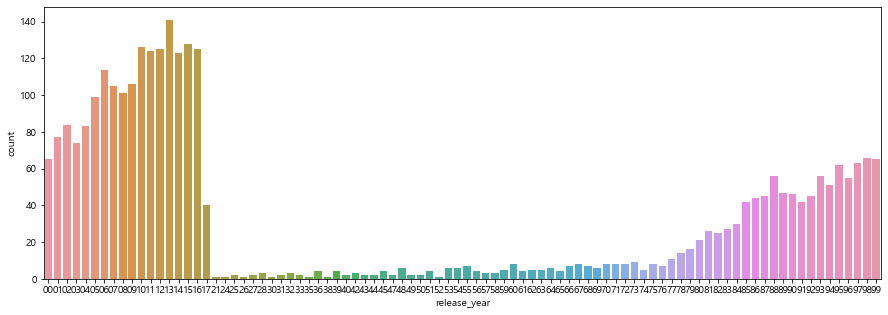

In [165]:
# 1900~1917과 2000~2017의 구분이 필요!
fig, axes = plt.subplots(ncols=1, figsize=(15,5))
sns.countplot(x = 'release_year', data=train)
plt.show()

#### - year가 21 이상은 1900, 20 이하는 2000 더하기 -> 1920년까지의 영화 찾을 수 있는 방법 생각하기(ex. 홈페이지 유무)

In [366]:
train['release_year'] = train['release_year'].astype('int')
test['release_year'] = test['release_year'].astype('int')

train['release_year'] = np.where(train['release_year']>20, train['release_year']+1900, train['release_year']+2000)
test['release_year'] = np.where(test['release_year']>20, test['release_year']+1900, test['release_year']+2000)

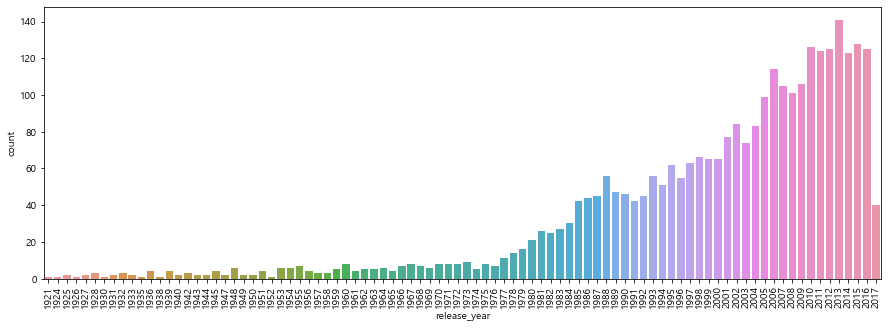

In [192]:
fig, axes = plt.subplots(ncols=1, figsize=(15,5))
sns.countplot(x = 'release_year', data=train)
plt.xticks(rotation=90)
plt.show()

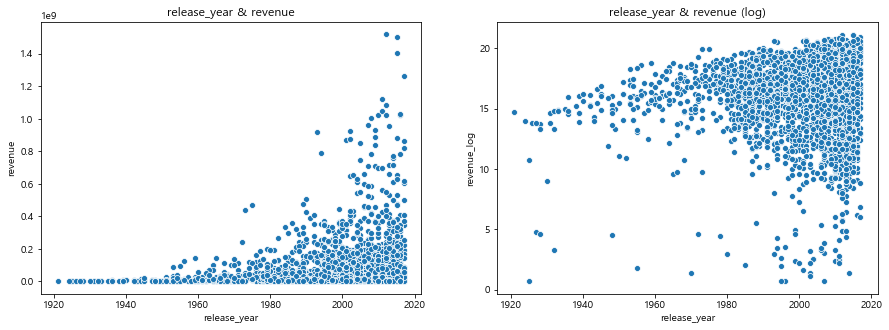

In [466]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
sns.scatterplot('release_year', 'revenue', data=train, ax=axes[0])
sns.scatterplot('release_year', 'revenue_log', data=train, ax=axes[1])
axes[0].set_title('release_year & revenue')
axes[1].set_title('release_year & revenue (log)')
plt.show()

### overview

### tagline

### 값이 dict인 변수들

In [29]:
from ast import literal_eval

In [393]:
def literal_change(value):
    try: 
        return literal_eval(value)[0]
    except (ValueError, SyntaxError) as e:
        return value

In [359]:
def make_cols(df, col):
    
    df[col] = df[col].apply(literal_change)
    
    keys = list(df[df[col].notnull()][col][0].keys())
    for key in keys:
        temp = []
        for val in df[col]:
            try:
                temp.append(val[key])
            except:
                temp.append(val)
        df[f"{col}_{key}"] = temp
    return df

### belongs_to_collection

In [368]:
train = make_cols(train, 'belongs_to_collection')

### genres

In [369]:
train = make_cols(train, 'genres')

### production_companies

In [370]:
train = make_cols(train, 'production_companies')

### production_countries

In [371]:
train = make_cols(train, 'production_countries')

### spoken_languages

In [372]:
train = make_cols(train, 'spoken_languages')

### Keywords

In [373]:
train = make_cols(train, 'Keywords')

### cast
- 함수 수정 필요.......😢

In [377]:
train['cast'][0]

"[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character

### crew

In [396]:
train = make_cols(train, 'crew')

### imdb_id

### poster_path

### status
- 큰 특징 없음

In [209]:
train['status'].value_counts()

Released    2996
Rumored        4
Name: status, dtype: int64

In [210]:
train[train['status']=='Rumored']

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,release_year
609,610,"[{'id': 144200, 'name': 'Swan Princess Series'...",0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 16, 'na...",NaN,tt0120254,en,The Swan Princess: Escape from Castle Mountain,The first wedding anniversary of Princess Odet...,5.121309,...,71.0,"[{'iso_639_1': 'da', 'name': 'Dansk'}, {'iso_6...",Rumored,It Will Take All Her Magic to Rescue Her Friends!,The Swan Princess: Escape from Castle Mountain,"[{'id': 3071, 'name': 'prince'}, {'id': 4456, ...","[{'cast_id': 2, 'character': 'Odette (voice)',...","[{'credit_id': '52fe488bc3a36847f816cfd3', 'de...",273644,1997
1007,1008,,0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt1860180,en,Billy Gardell: Halftime,"Billy Gardell, the star of CBS' hit comedy ""Mi...",0.007877,...,60.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Rumored,NaN,Billy Gardell: Halftime,NaN,"[{'cast_id': 9, 'character': 'Himself', 'credi...","[{'credit_id': '52fe4be1c3a368484e19d265', 'de...",60,2011
1216,1217,,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,tt0091024,en,Extremities,A woman escapes from the man who is about to r...,10.273979,...,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Rumored,"When fear made her a victim, she turned fear i...",Extremities,"[{'id': 2483, 'name': 'nudity'}, {'id': 2539, ...","[{'cast_id': 1, 'character': 'Marjorie', 'cred...","[{'credit_id': '582cca1c925141780b00259f', 'de...",13418091,1986
1618,1619,,891000,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0145394,en,A Place Called Chiapas,"On January 1, 1994, the Zapatista National Lib...",0.179246,...,89.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Rumored,Inside the world's first postmodern revolution,A Place Called Chiapas,"[{'id': 187056, 'name': 'woman director'}]","[{'cast_id': 1, 'character': 'Himself', 'credi...","[{'credit_id': '57b4f7619251417287000dfc', 'de...",229000,1998
